# XGBoost

In [187]:
# Import bibliotek
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_curve, recall_score, roc_auc_score, precision_recall_fscore_support, accuracy_score, classification_report, ConfusionMatrixDisplay
from imblearn.over_sampling import SMOTENC
import xgboost as xgb

warnings.filterwarnings('ignore')

In [188]:
# === Załadowanie danych ===
train_df = pd.read_csv('train_df.csv', index_col=0)
test_df = pd.read_csv('test_df.csv', index_col=0)

# Dodanie kolumny `__is_train` w celu rozróżnienia zbiorów
train_df['__is_train'] = 1
test_df['__is_train'] = 0

# Połączenie zbiorów
combined = pd.concat([train_df, test_df], axis=0)

# One-Hot Encoding
combined = pd.get_dummies(combined, drop_first=True)
train_df = combined[combined['__is_train'] == 1].drop(columns='__is_train')
test_df = combined[combined['__is_train'] == 0].drop(columns='__is_train')

# Podział na cechy (X) i etykiety (y)
X_train = train_df.drop('stroke', axis=1)
y_train = train_df['stroke']
X_test = test_df.drop('stroke', axis=1)
y_test = test_df['stroke']


In [189]:
# Indeksy cech kategorycznych po One-Hot Encoding
index_of_categorical_features = [1, 2, 5, 6, 7, 8, 9, 10, 11]

# === Zastosowanie SMOTENC ===
sm = SMOTENC(categorical_features=index_of_categorical_features, random_state=42, sampling_strategy='auto')
X_train_resampled, y_train_resampled = sm.fit_resample(X_train, y_train)

print("Rozmiar danych po SMOTENC:")
print("X_train_resampled shape:", X_train_resampled.shape)
print("y_train_resampled shape:", y_train_resampled.shape)

Rozmiar danych po SMOTENC:
X_train_resampled shape: (7784, 12)
y_train_resampled shape: (7784,)


## Grid Search – dobór optymalnych hiperparametrów

In [190]:
param_grid = {
    'n_estimators': [30, 40, 50, 60],
    'max_depth': [3, 4, 5, 6],
    'learning_rate': [0.02, 0.03, 0.04],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.8, 1.0],
    'scale_pos_weight': [3, 4, 5, 6]
}

xgb_model = xgb.XGBClassifier(
    objective='binary:logistic',
    eval_metric='auc',
    random_state=42
)

grid_search = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid,
    scoring='roc_auc',
    cv=3,
    n_jobs=-1,
    verbose=0
)

print("Rozpoczynam Grid Search dla XGBoost...")
grid_search.fit(X_train_resampled, y_train_resampled)

# Najlepsze parametry
print(f"Najlepsze parametry:{grid_search.best_params_}")
print(f"Najlepszy wynik AUC na zbiorze walidacyjnym: {grid_search.best_score_}")

Rozpoczynam Grid Search dla XGBoost...
Najlepsze parametry:{'colsample_bytree': 0.8, 'learning_rate': 0.04, 'max_depth': 6, 'n_estimators': 60, 'scale_pos_weight': 4, 'subsample': 0.8}
Najlepszy wynik AUC na zbiorze walidacyjnym: 0.9442176296651649


**Komentarz**

Przeprowadzono **Grid Search**, aby znaleźć **najlepsze hiperparametry** dla modelu `XGBoost`.

Jako metrykę oceny modelu wybrano **AUC (Area Under the Curve)**, ponieważ AUC mierzy zdolność modelu do rozróżniania klas `0` i `1`.
W kontekście danych dotyczących predykcji udarów, istotne jest, aby model **nie tylko osiągał wysoką dokładność (Accuracy)**, ale także **skutecznie wykrywał przypadki `1` (udar)**, nawet kosztem większej liczby fałszywych alarmów (`FP`).  
AUC jest bardziej adekwatną metryką w sytuacji, gdy mamy do czynienia z **niezrównoważonymi danymi**, co pozwala lepiej ocenić zdolność modelu do wykrywania udarów (`1`).  
Dlatego w tej analizie, **maksymalizacja AUC** pozwala na znalezienie optymalnych parametrów, które **zwiększą szansę na wykrycie udarów**, jednocześnie kontrolując liczbę fałszywych alarmów.  

In [191]:
# === Inicjalizacja modelu z najlepszymi parametrami ===
best_xgb_model = xgb.XGBClassifier(
    objective='binary:logistic',
    eval_metric='auc',
    random_state=42,
    **grid_search.best_params_ 
)

# === Trenowanie modelu na danych po SMOTENC ===
best_xgb_model.fit(X_train_resampled, y_train_resampled)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='auc', feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.04, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=6,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=60,
              n_jobs=None, num_parallel_tree=None, ...)

## Ocena modelu na zbiorze treningowym i prezentacja metryk

In [192]:
# Przewidywanie prawdopodobieństw
y_proba = best_xgb_model.predict_proba(X_test)[:, 1]

# Zastosowanie progu 0.5 do generowania prognoz binarnych
y_pred = (y_proba >= 0.5).astype(int)

# Obliczanie metryk
accuracy = accuracy_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_proba)
recall = recall_score(y_test, y_pred)
precision, recall_macro, f1_score_macro, _ = precision_recall_fscore_support(y_test, y_pred, average='macro')

# Wyświetlenie wyników
print(f"Confusion Matrix:\n{confusion_matrix(y_test, y_pred)}")
print(f"Accuracy: {accuracy:.4f}")
print(f"AUC: {auc:.4f}")
print(f"TPR (Recall): {recall:.4f}")
print(f"Macro avg Precision: {precision:.4f}")
print(f"Macro avg Recall: {recall_macro:.4f}")
print(f"Macro avg F1-score: {f1_score_macro:.4f}")


Confusion Matrix:
[[651 317]
 [ 19  35]]
Accuracy: 0.6712
AUC: 0.7493
TPR (Recall): 0.6481
Macro avg Precision: 0.5355
Macro avg Recall: 0.6603
Macro avg F1-score: 0.4836


**Komentarz**

Dla modelu `XGBoost` z **najlepszymi hiperparametrami wybranymi w Grid Search**, uzyskano **Accuracy na poziomie 0.6712**.  
Jednak w kontekście analizy medycznej, gdzie **priorytetem jest wykrycie przypadków udaru (`1`)**, Accuracy **nie jest kluczową metryką**, ponieważ może być zawyżone przez dużą liczbę poprawnie sklasyfikowanych przypadków `0`.  

Bardziej istotna jest tutaj **wartość AUC**, która wyniosła **0.7493**, co wskazuje na **optymalną zdolność modelu do rozróżniania przypadków `0` i `1`. 
**Recall (0.6481)** wskazuje, że model wykrył **około 65% przypadków udaru**, ale pozostaje przestrzeń do poprawy w kontekście przeoczonych przypadków (`FN = 19`).  
Precision uzyskało poziom **0.5355**, co oznacza, że spośród wszystkich przypadków zaklasyfikowanych jako `1`, tylko **53% faktycznie było przypadkami udaru**.  

W dalszej części analizy warto **dostosować próg decyzyjny**, aby **zwiększyć Recall (`TPR`)**, co może być bardziej wartościowe w kontekście medycznym niż optymalizacja Accuracy.  


In [193]:
# Przewidywanie prawdopodobieństw
y_proba = best_xgb_model.predict_proba(X_test)[:, 1]

# Zmniejszenie progu do 0.3
y_pred = (y_proba >= 0.3).astype(int)

accuracy = accuracy_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_proba)
recall = recall_score(y_test, y_pred)
precision, recall_macro, f1_score_macro, _ = precision_recall_fscore_support(y_test, y_pred, average='macro')

# Wyświetlenie wyników
print(f"Confusion Matrix:\n{confusion_matrix(y_test, y_pred)}")
print(f"Accuracy: {accuracy:.4f}")
print(f"AUC: {auc:.4f}")
print(f"TPR (Recall): {recall:.4f}")
print(f"Macro avg Precision: {precision:.4f}")
print(f"Macro avg Recall: {recall_macro:.4f}")
print(f"Macro avg F1-score: {f1_score_macro:.4f}")


Confusion Matrix:
[[510 458]
 [  5  49]]
Accuracy: 0.5470
AUC: 0.7493
TPR (Recall): 0.9074
Macro avg Precision: 0.5435
Macro avg Recall: 0.7171
Macro avg F1-score: 0.4312


**Komentarz**

Zmniejszenie progu z **0.5 do 0.3** skutkowało **zwiększeniem TPR (Recall) z 0.6481 do 0.9074**, co oznacza, że model skuteczniej wykrywa przypadki udaru (`1`).  
Jednocześnie **Accuracy spadło do 0.5470**, ponieważ model częściej klasyfikuje `0` jako `1`, co zwiększa liczbę fałszywych alarmów (`FP`).  
W tym przypadku **zwiększenie Recall jest bardziej pożądane**, ponieważ **priorytetem jest wykrycie jak największej liczby przypadków udaru**, nawet kosztem większej liczby fałszywych alarmów.  


## Wizualizacja metryk

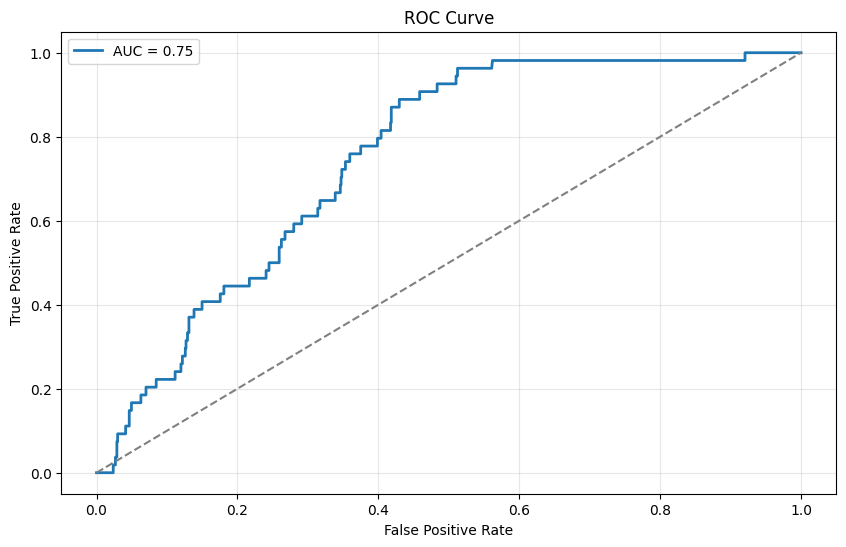

In [194]:
# === Wizualizacja ROC Curve ===
fpr, tpr, _ = roc_curve(y_test, y_proba)
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, label="AUC = {:.2f}".format(auc), linewidth=2)
plt.plot([0, 1], [0, 1], linestyle='--', color='grey')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

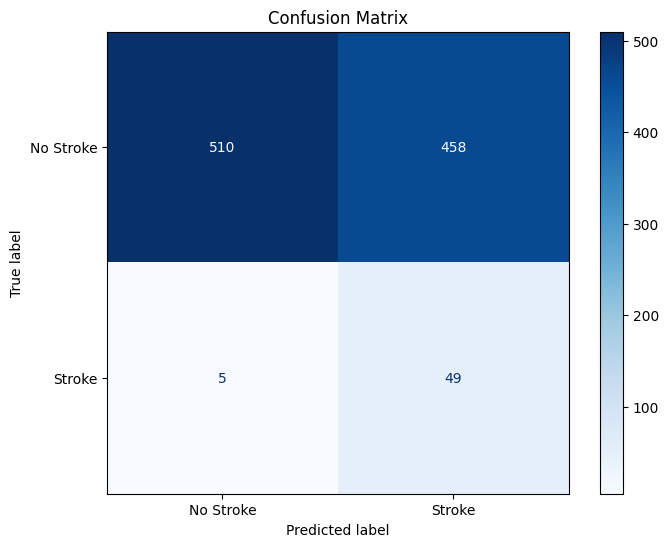

In [195]:
# === Confusion Matrix ===
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Generowanie confusion matrix
cm = confusion_matrix(y_test, y_pred)
cmd = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["No Stroke", "Stroke"])

# Wykres confusion matrix
fig, ax = plt.subplots(figsize=(8, 6))
cmd.plot(ax=ax, cmap="Blues", values_format="d")
plt.title("Confusion Matrix")
plt.grid(False)
plt.show()

## Podsumowanie metryk

1. AUC: 0.7493
2. TPR (Recall): 0.9074
3. Macro avg Precision: 0.5435
4. Macro avg Recall: 0.7171
5. Macro avg F1-score: 0.4312